In [1]:
import numpy as np
import h5py
import os
import pyedflib
from neurodsp.spectral import compute_spectrum
import scipy.signal
import scipy.io as sio
from fooof import FOOOF
from neurodsp.plts.time_series import plot_time_series
from neurodsp.utils import create_times
from neurodsp.filt import filter_signal
from fooof.bands import Bands
from fooof.analysis import get_band_peak_fm

In [16]:
# go to directory with first cortex sample
os.chdir('/Users/alissavalentine/ephys_rotation/MATfiles/cortex + target LFP/6_13_22')
directory_list = os.listdir()

In [17]:
edf_paths = []

for file in directory_list:
    if ".mat" in file:
        # loading data from mat lab file
        mat_data = sio.loadmat(file)
        # i want CRAW_01
        for key, value in mat_data.items():
            if key == "CRAW_01":
                data = np.array(value[0])
                duration = len(data) / 44000
                if duration >= 5:
                    #print(data)
                    #print(data.shape)
                    new_file_name = file.split('.mat')[0] + '.hdf5'
                    new_path = '/Users/alissavalentine/ephys_rotation/MATfiles/cortex + target LFP/6_13_22/hdf5' + '/' + new_file_name
                    edf_paths.append(new_path)
                    f = h5py.File(new_path, "w")
                    f.create_dataset('data', data=data[:], dtype='<i2')
                    f.close()


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 5 - 45 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          6.0145, 3.5054                                          
                                                                                                  
                                       2 peaks were found:                                        
          

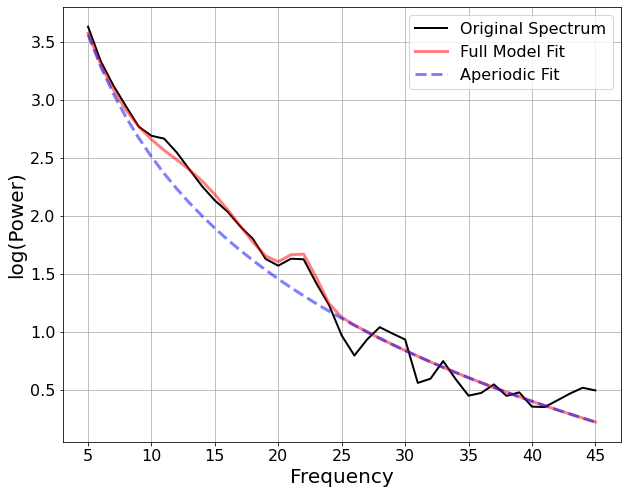

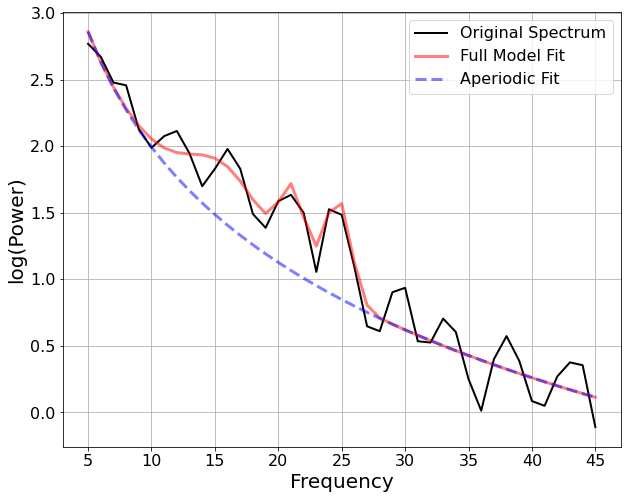

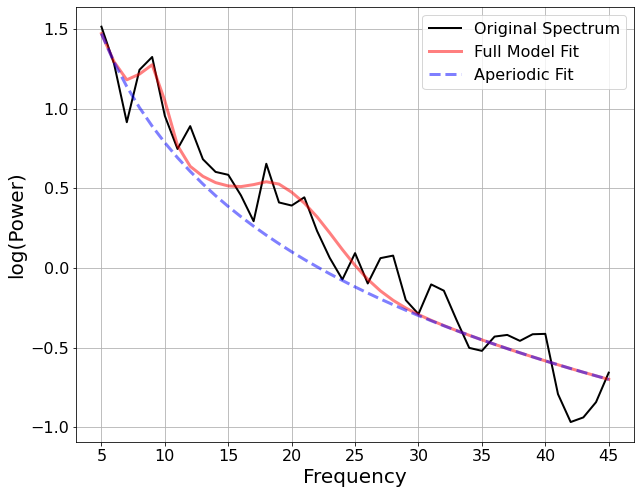

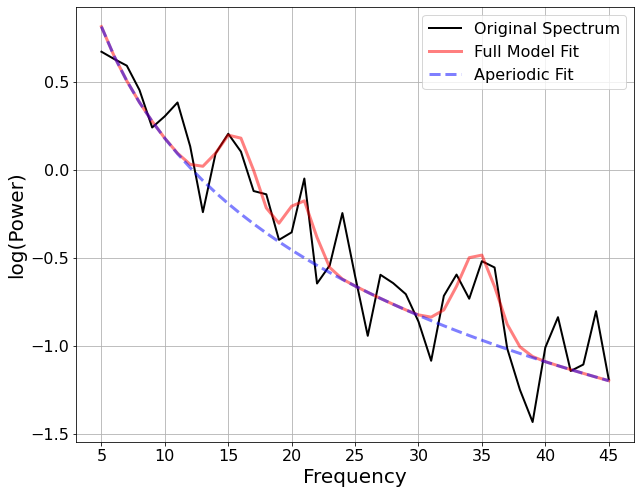

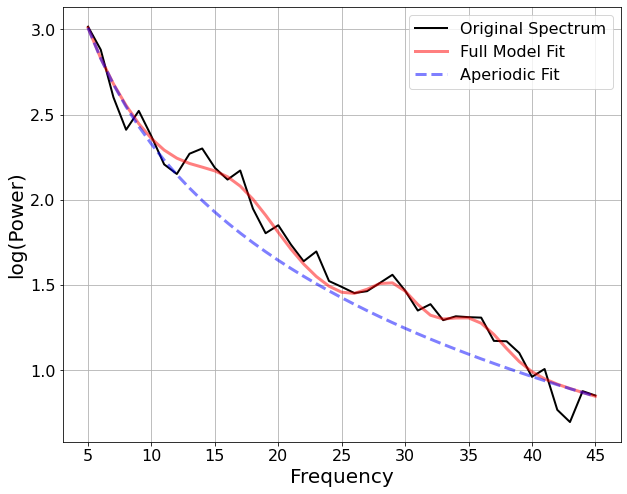

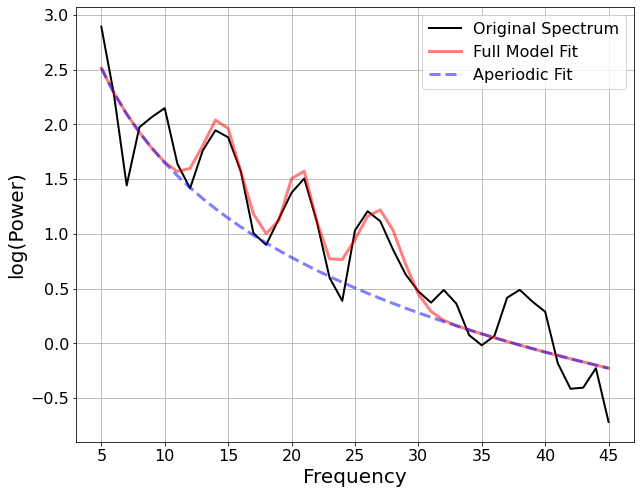

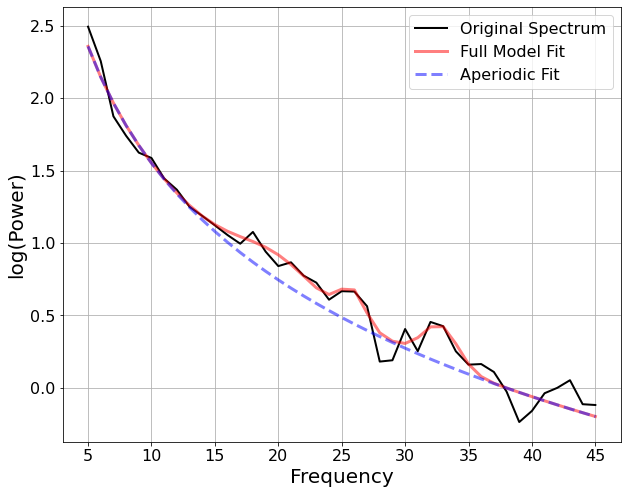

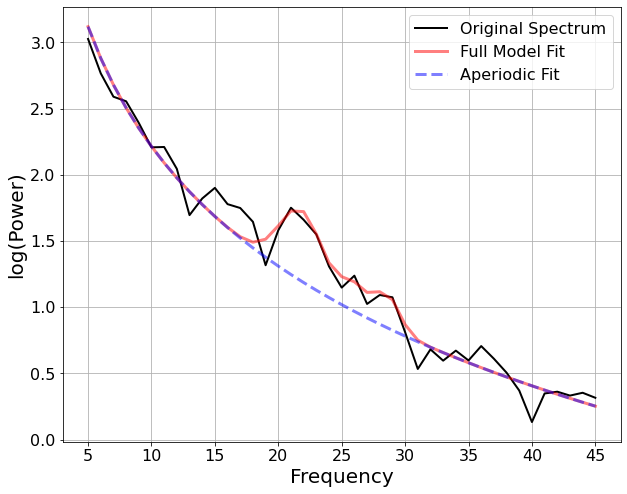

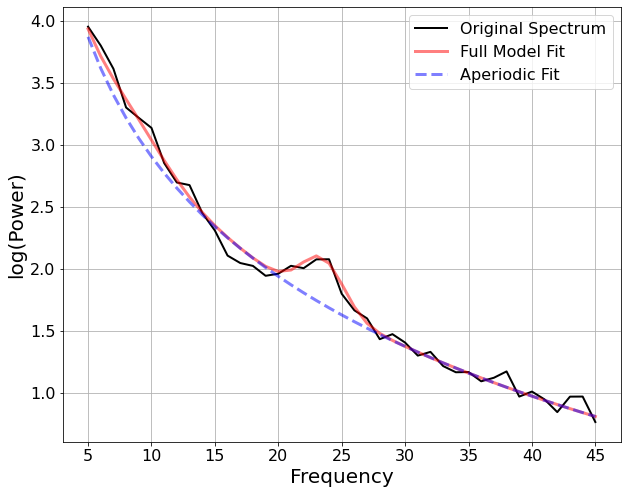

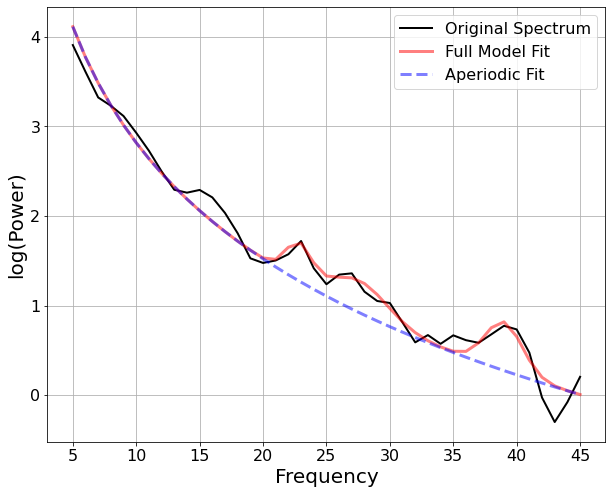

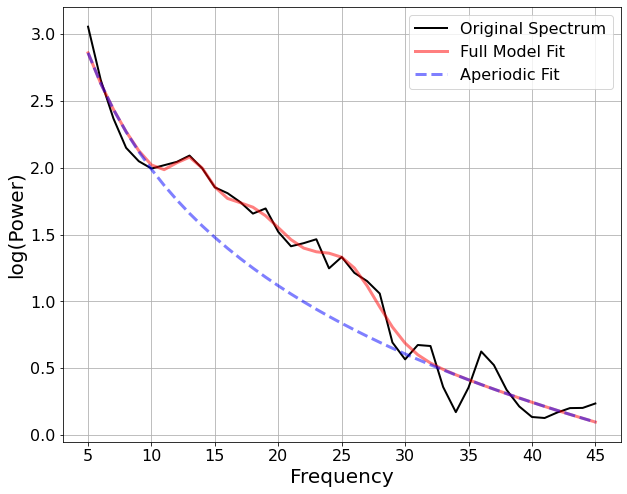

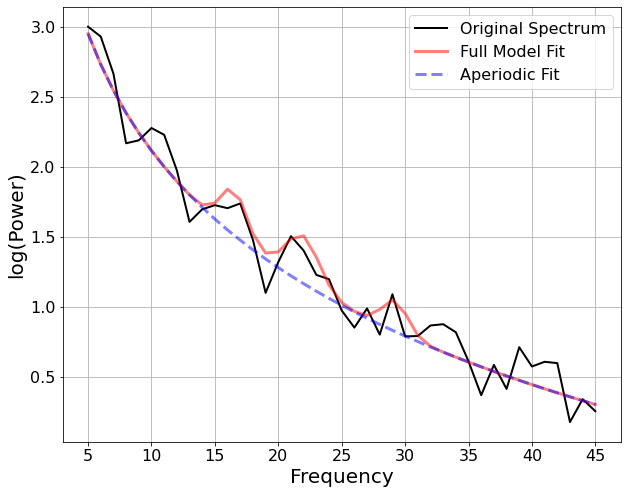

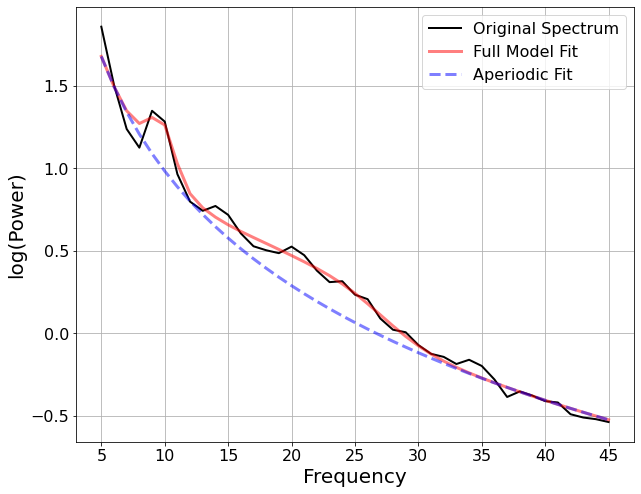

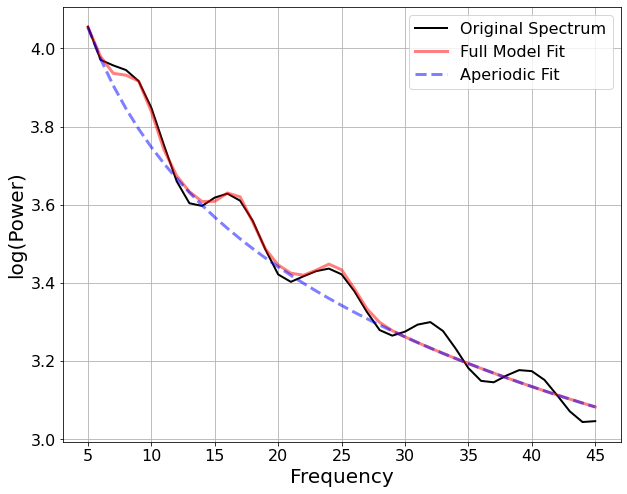

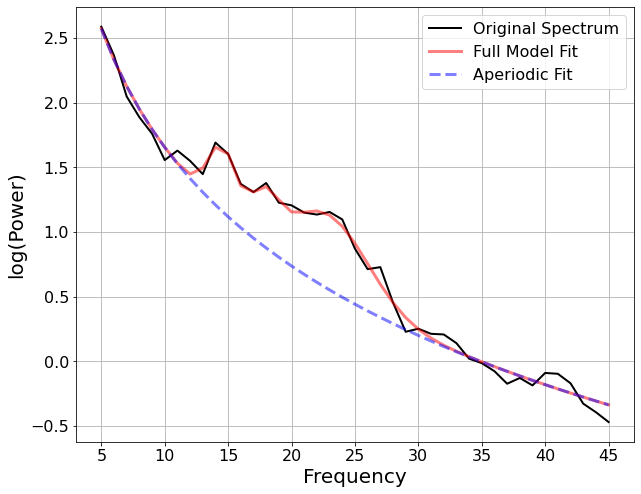

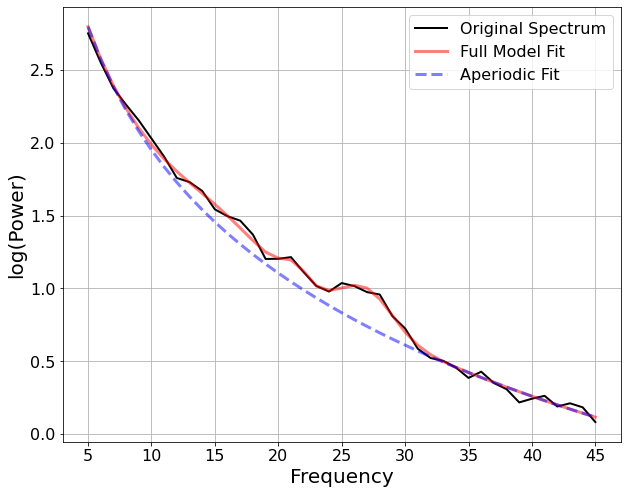

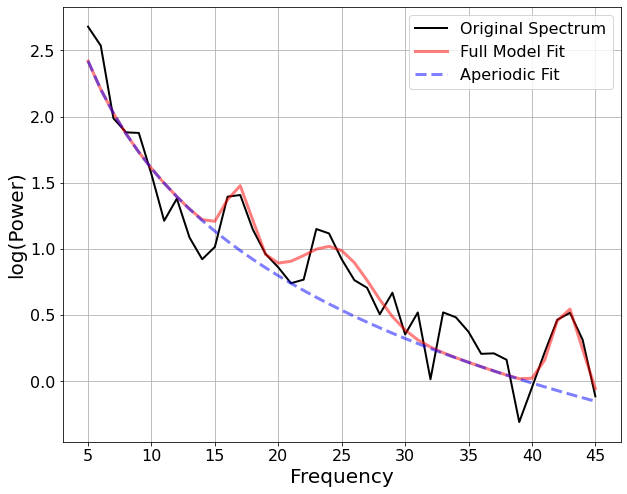

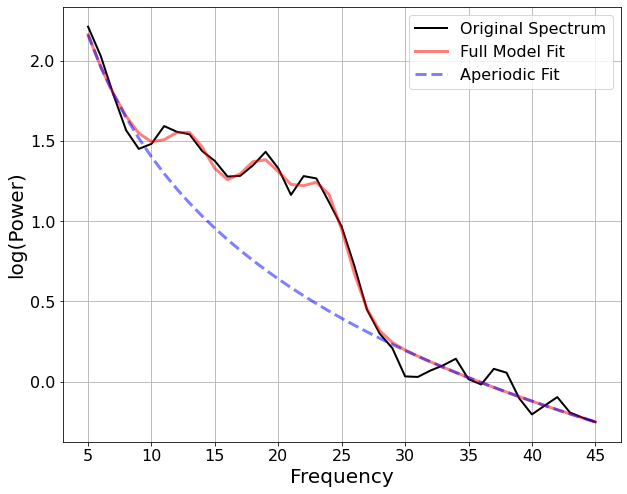

In [18]:
for path in edf_paths:
    file_name = path.split('.hdf5')[0].rsplit('/')[-1].replace(".", "_")
    # read the h5py file
    with h5py.File(path, "r") as f:
        # save raw data as np.float64
        raw_signal = np.array(f.get('data'), dtype=np.float64)
        #print(raw_signal)
        # bandpass filter signal using sample rate and f range
        filtered_signal = filter_signal(raw_signal, 44000, 'bandpass', (2,50))
        # # remove nan values from filtered signal
        filtered_signal = np.array([x for x in filtered_signal if np.isnan(x) == False])
        # # downsample the data
        secs = len(filtered_signal) / 44000  # Number of seconds in signal X
        samps = int(secs * 1000)  # Number of samples to downsample
        down_filtered_signal = scipy.signal.resample(filtered_signal, samps)
        # optional plots to see the filtered data (uncomment them to see them)
        # times = create_times((len(raw_signal)/44000), 44000)
        # times2 = create_times((len(filtered_signal)/44000), 44000)
        # plot_time_series(times, raw_signal, ['Raw'])
        # plot_time_series(times2, filtered_signal, ['Filtered'])
        # compute power spectrum analysis with welch method and given f range
        freqs, powers = compute_spectrum(down_filtered_signal, 1000, f_range=(2,50))
        # Initialize a FOOOF object
        # manually change parameters as needed
        fm = FOOOF(peak_width_limits=[2, 7], min_peak_height=0.05, max_n_peaks=3, verbose=True)
        # fit FOOOF model to power spectrum data
        fm.fit(freqs, powers)
        # generate report and save the report to output directory
        fm.report(freqs, powers, [5, 45])
        # update the file path to what you want
        fm.save_report(file_name=file_name, file_path='/Users/alissavalentine/ephys_rotation/MATfiles/cortex + target LFP/6_13_22/hdf5/reports/')